<a href="https://colab.research.google.com/github/davidarvai/DIPLOMADOLGOZAT/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import math
import random
import numpy as np
import nibabel as nib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

base_output_dir = "/content/drive/My Drive/Allamvizsga/OutputCNN"

# Result output folders: test results and final learning curves
eredmeny_dir = os.path.join(base_output_dir, "Eredmeny")
os.makedirs(eredmeny_dir, exist_ok=True)

# ModelSave folder: saving checkpoints, training logs, and training state
modelsave_dir = os.path.join(base_output_dir, "ModelSave")
os.makedirs(modelsave_dir, exist_ok=True)

# File paths in the ModelSave folder
checkpoint_path = os.path.join(modelsave_dir, "model_checkpoint.weights.h5")
csv_logger_path = os.path.join(modelsave_dir, "training_log.csv")
training_state_path = os.path.join(modelsave_dir, "training_state.txt")
all_training_log_path = os.path.join(modelsave_dir, "all_training_log.csv")


os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Helper functions and confusion matrix
def get_custom_confusion_matrix(tumor_type, tn, fp, fn, tp):
    if tumor_type == "Whole Tumor":
        custom_matrix = np.array([[tn, fp, fp, fp],
                                  [fn, tp, tp, tp],
                                  [fn, tp, tp, tp],
                                  [fn, tp, tp, tp]])
    elif tumor_type == "Edema":
        custom_matrix = np.array([[tn, tn, fp, tn],
                                  [tn, tn, fp, tn],
                                  [fn, fn, tp, fn],
                                  [tn, tn, fp, tn]])
    elif tumor_type == "Tumor Core":
        custom_matrix = np.array([[tn, fp, tn, fp],
                                  [fn, tp, fn, tp],
                                  [tn, fp, tn, fp],
                                  [fn, tp, fn, tp]])
    elif tumor_type == "Enhancing Core":
        custom_matrix = np.array([[tn, tn, tn, fp],
                                  [tn, tn, tn, fp],
                                  [tn, tn, tn, fp],
                                  [fn, fn, fn, tp]])
    else:
        custom_matrix = None
    return custom_matrix

# Calculates the number of true negatives, false positives, false negatives, and true positives.
def compute_confusion(gt_mask, pred_mask):
    tn = np.sum((gt_mask == False) & (pred_mask == False))
    tp = np.sum((gt_mask == True)  & (pred_mask == True))
    fp = np.sum((gt_mask == False) & (pred_mask == True))
    fn = np.sum((gt_mask == True)  & (pred_mask == False))
    return tn, fp, fn, tp

# Computes standard evaluation metrics like TPR, TNR, PPV, NPV, ACC, and Dice Score.
def compute_metrics(tn, fp, fn, tp):
    TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
    TNR = tn / (tn + fp) if (tn + fp) > 0 else 0
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0
    ACC = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    DS  = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    return TPR, TNR, PPV, NPV, ACC, DS

# Converts label 4 in the segmentation mask to 3
def remap_segmentation(seg):
    seg_new = np.copy(seg)
    seg_new[seg == 4] = 3
    return seg_new

# Loads all relevant image and segmentation file paths for a subject.
def load_subject_data(subject_path):
    files = os.listdir(subject_path)
    subject_data = {}
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            lower = file.lower()
            if 'seg' in lower:
                subject_data['seg'] = os.path.join(subject_path, file)
            else:
                for mod in ['t1', 't1ce', 't2', 'flair']:
                    if mod in lower:
                        subject_data[mod] = os.path.join(subject_path, file)
    return subject_data

def normalize_volume(vol):
    vol = vol.astype(np.float32)
    vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1e-8)
    return vol


# Custom Keras generator to yield 2D slices with optional augmentation for training/validation.
class SliceDataGenerator(Sequence):
    def __init__(self, subject_dirs, batch_size=8, slice_axis=2,
                 include_bg_ratio=0.3, shuffle=True, augment=False):
        self.subject_dirs    = subject_dirs
        self.batch_size      = batch_size
        self.slice_axis      = slice_axis
        self.include_bg_ratio= include_bg_ratio
        self.shuffle         = shuffle
        self.augment         = augment
        self.all_slices      = []

        # Creating a list of (subject_dir, slice_index) pairs.
        for subject in self.subject_dirs:
            data_files = load_subject_data(subject)
            if 'seg' not in data_files:
                continue
            seg = nib.load(data_files['seg']).get_fdata()
            D = seg.shape[self.slice_axis]
            for i in range(D):
                slice_mask = seg.take(indices=i, axis=self.slice_axis)
                if np.sum(slice_mask > 0) > 0.01 * slice_mask.size \
                   or random.random() < self.include_bg_ratio:
                    self.all_slices.append((subject, i))

        if self.shuffle:
            random.shuffle(self.all_slices)

    def __len__(self):
        return math.ceil(0.5 * len(self.all_slices) / self.batch_size)

    def __getitem__(self, idx):
        batch = self.all_slices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, Y_batch = [], []

        for subject, slice_idx in batch:
            data_files = load_subject_data(subject)

            # Loading and normalization
            modality_imgs = [
                normalize_volume(nib.load(data_files[mod]).get_fdata())
                for mod in ['t1', 't1ce', 't2', 'flair']
            ]
            X_vol = np.stack(modality_imgs, axis=-1)
            seg   = remap_segmentation(nib.load(data_files['seg']).get_fdata())

            img_slice = X_vol.take(indices=slice_idx, axis=2)
            seg_slice = seg.take(indices=slice_idx, axis=2)

            # Augmentation only if augment=True
            if self.augment:
                if random.random() < 0.5:
                    img_slice = np.flip(img_slice, axis=0)
                    seg_slice = np.flip(seg_slice, axis=0)
                if random.random() < 0.5:
                    img_slice = np.flip(img_slice, axis=1)
                    seg_slice = np.flip(seg_slice, axis=1)

            X_batch.append(img_slice)
            Y_batch.append(seg_slice)

        return np.array(X_batch), np.array(Y_batch)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.all_slices)

# Callback for saving the training state
class SaveTrainingStateCallback(tf.keras.callbacks.Callback):
    def __init__(self, training_state_path):
        super(SaveTrainingStateCallback, self).__init__()
        self.training_state_path = training_state_path

    def on_epoch_end(self, epoch, logs=None):
        with open(self.training_state_path, 'w') as f:
            f.write(str(epoch + 1))
        print(f"Training state updated: epoch {epoch+1} saved to {self.training_state_path}")


# Callback for accumulating all episode data into a single file
class AccumulateTrainingLogCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(AccumulateTrainingLogCallback, self).__init__()
        self.file_path = file_path
        if not os.path.exists(self.file_path):
            with open(self.file_path, 'w') as f:
                f.write("epoch,loss,accuracy,val_loss,val_accuracy\n")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'a') as f:
            f.write(f"{epoch+1},{logs.get('loss')},{logs.get('accuracy')},{logs.get('val_loss')},{logs.get('val_accuracy')}\n")


# New CSV logger callback that adjusts episode numbering to start from 1
class ShiftedCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename, separator=',', append=False):
        super(ShiftedCSVLogger, self).__init__()
        self.filename = filename
        self.sep = separator
        self.append = append
        self.keys = None
        self.file = None
        self.append_header = True

    def on_train_begin(self, logs=None):
        if self.append and os.path.exists(self.filename):
            self.file = open(self.filename, 'a', newline='')
            self.append_header = False
        else:
            self.file = open(self.filename, 'w', newline='')
            self.append_header = True

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["epoch"] = epoch + 1
        if self.keys is None:
            self.keys = sorted(logs.keys())
            if self.append_header:
                header = self.sep.join(self.keys)
                self.file.write(header + "\n")
        row = self.sep.join(str(logs.get(key, "")) for key in self.keys)
        self.file.write(row + "\n")
        self.file.flush()

    def on_train_end(self, logs=None):
        if self.file:
            self.file.close()


# Model definition and loss functions
def unet2d_model(input_shape, n_filters=32, n_classes=4):
    inputs = Input(input_shape, name="input_layer")

    # Encoder blokk 1
    c1 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d")(inputs)
    c1 = BatchNormalization(name="bn1")(c1)
    c1 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_1")(c1)
    c1 = BatchNormalization(name="bn2")(c1)
    c1 = Dropout(0.1, name="dropout_c1")(c1)
    p1 = MaxPooling2D((2, 2), name="max_pooling2d")(c1)

    # Encoder blokk 2
    c2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_2")(p1)
    c2 = BatchNormalization(name="bn3")(c2)
    c2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_3")(c2)
    c2 = BatchNormalization(name="bn4")(c2)
    c2 = Dropout(0.1, name="dropout_c2")(c2)
    p2 = MaxPooling2D((2, 2), name="max_pooling2d_1")(c2)

    # Bottleneck
    c3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_4")(p2)
    c3 = BatchNormalization(name="bn5")(c3)
    c3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-5), name="conv2d_5")(c3)
    c3 = BatchNormalization(name="bn6")(c3)
    c3 = Dropout(0.3, name="dropout_c3")(c3)

    # Decoder blokk 1
    u2 = UpSampling2D((2, 2), name="up_sampling2d")(c3)
    u2 = concatenate([u2, c2], name="concatenate")
    c4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_6")(u2)
    c4 = BatchNormalization(name="bn7")(c4)
    c4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_7")(c4)
    c4 = BatchNormalization(name="bn8")(c4)

    # Decoder blokk 2
    u1 = UpSampling2D((2, 2), name="up_sampling2d_1")(c4)
    u1 = concatenate([u1, c1], name="concatenate_1")
    c5 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_8")(u1)
    c5 = BatchNormalization(name="bn9")(c5)
    c5 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_9")(c5)
    c5 = BatchNormalization(name="bn10")(c5)

    outputs = Conv2D(n_classes, 1, activation='softmax', name="conv2d_10")(c5)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Calculates the Dice loss for 2D multi-class segmentation by measuring the overlap between predicted and true labels.

def dice_loss_2d(y_true, y_pred, smooth=1e-4):
    if y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=4)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

# Computes a combined loss by adding Sparse Categorical Crossentropy and Dice loss to improve segmentation performance.

def combined_loss_2d(y_true, y_pred):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    d_loss = dice_loss_2d(y_true, y_pred)
    return ce_loss + d_loss


# Helper function for listing patient folders
def get_subject_dirs(data_dir):
    return sorted([os.path.join(data_dir, d) for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))])


# Main program
if __name__ == "__main__":
    train_dir = "/content/drive/My Drive/Allamvizsga/Data/Teszt/Train"
    test_dir = "/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt"

    # Collecting patient folders and splitting into Train/Val
    # The dataset is split into 80% for training and 20% for validation.
    all_train_subjects = get_subject_dirs(train_dir)
    if len(all_train_subjects) == 0:
        raise ValueError("No train data loaded!")
    train_subjects, val_subjects = train_test_split(all_train_subjects, test_size=0.2, random_state=42)

    # Creating data generators
    batch_size = 8
    train_generator = train_generator = SliceDataGenerator(train_subjects,batch_size=8,slice_axis=2,include_bg_ratio=0.3,shuffle=True,augment=True)
    val_generator = SliceDataGenerator(val_subjects,batch_size=8,slice_axis=2,include_bg_ratio=0.0,shuffle=False,augment=False)

    # Creating the model
    X_sample, _ = train_generator[0]
    input_shape = X_sample.shape[1:]
    model = unet2d_model(input_shape=input_shape, n_filters=32, n_classes=4)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=combined_loss_2d, metrics=['accuracy'])
    model.summary()

    # loading previous checkpoint if available
    initial_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Previous checkpoint found, loading...")
        model.load_weights(checkpoint_path)
        if os.path.exists(training_state_path):
            with open(training_state_path, 'r') as f:
                try:
                    initial_epoch = int(f.read().strip())
                    print(f"Continuing from {initial_epoch}. episode.")
                except Exception as e:
                    print("Error while loading the training state, restarting the training.")
                    initial_epoch = 0

    # Defining callbacks: checkpoint, Shifted CSV logger, saving training state, and accumulating log callback
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    shifted_csv_logger = ShiftedCSVLogger(csv_logger_path, append=True)
    training_state_callback = SaveTrainingStateCallback(training_state_path)
    accumulated_log_callback = AccumulateTrainingLogCallback(all_training_log_path)

    # Tréning
    epochs = 20
    History = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint_callback, shifted_csv_logger, training_state_callback, accumulated_log_callback]
    )

    # Plotting graphs based on the all_training_log.csv file
    full_history = pd.read_csv(all_training_log_path)

    # Loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Validation Loss')
    plt.title('Full loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    full_loss_path = os.path.join(eredmeny_dir, 'full_loss_curve.png')
    plt.savefig(full_loss_path)
    plt.close()
    print(f"Full loss curve saved: {full_loss_path}")

    # Accuracy curve
    plt.figure(figsize=(8, 6))
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Full accuracy curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    full_acc_path = os.path.join(eredmeny_dir, 'full_accuracy_curve.png')
    plt.savefig(full_acc_path)
    plt.close()
    print(f"Full accuracy curve saved: {full_acc_path}")

    # Testing
    test_subjects = get_subject_dirs(test_dir)
    if len(test_subjects) == 0:
        raise ValueError("No test data loaded!")
    metrics_rows = []
    output_txt_lines = []
    tumor_types = ["Whole Tumor", "Edema", "Tumor Core", "Enhancing Core"]

    for subject in test_subjects:
        data_files = load_subject_data(subject)
        if 'seg' not in data_files:
            continue
        modality_imgs = []
        for mod in ['t1', 't1ce', 't2', 'flair']:
            img = nib.load(data_files[mod]).get_fdata()
            modality_imgs.append(normalize_volume(img))
        X_vol = np.stack(modality_imgs, axis=-1)
        seg = nib.load(data_files['seg']).get_fdata()
        seg = remap_segmentation(seg)
        H, W, D, _ = X_vol.shape
        pred_vol = np.zeros((H, W, D), dtype=np.int32)
        for i in range(D):
            x_slice = X_vol[:, :, i, :]
            x_slice = np.expand_dims(x_slice, axis=0)
            pred_slice = model.predict(x_slice)[0]
            pred_slice = np.argmax(pred_slice, axis=-1)
            pred_vol[:, :, i] = pred_slice

        def get_binary_mask_3d(segmentation, tumor_type):
            if tumor_type == "Whole Tumor":
                return np.isin(segmentation, [1, 2, 3])
            elif tumor_type == "Edema":
                return (segmentation == 2)
            elif tumor_type == "Tumor Core":
                return np.isin(segmentation, [1, 3])
            elif tumor_type == "Enhancing Core":
                return (segmentation == 3)
            else:
                raise ValueError("Unknown tumor type!")
        for tumor in tumor_types:
            gt_mask = get_binary_mask_3d(seg, tumor)
            pred_mask = get_binary_mask_3d(pred_vol, tumor)
            tn, fp, fn, tp = compute_confusion(gt_mask, pred_mask)
            TPR, TNR, PPV, NPV, ACC, DS = compute_metrics(tn, fp, fn, tp)
            cm = get_custom_confusion_matrix(tumor, tn, fp, fn, tp)

            metrics_rows.append({
                "Name": os.path.basename(subject),
                "TumorType": tumor,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TPR": round(TPR, 3),
                "TNR": round(TNR, 3),
                "PPV": round(PPV, 3),
                "NPV": round(NPV, 3),
                "ACC": round(ACC, 3),
                "DS": round(DS, 3)
            })

            txt_block = (f"Folder name: {os.path.basename(subject)}\nTumor type: {tumor}\nConfusion matrix:\n{cm}\n"
                         f"TPR: {round(TPR, 3)}\nTNR: {round(TNR, 3)}\nPPV: {round(PPV, 3)}\nNPV: {round(NPV, 3)}\n"
                         f"ACC: {round(ACC, 3)}\nDS: {round(DS, 3)}\n\n")
            output_txt_lines.append(txt_block)

    metrics_df = pd.DataFrame(metrics_rows, columns=["Name", "TumorType", "TP", "TN", "FP", "FN", "TPR", "TNR", "PPV", "NPV", "ACC", "DS"])
    metrics_csv_path = os.path.join(eredmeny_dir, "metrics_output.csv")
    metrics_df.to_csv(metrics_csv_path, index=False)
    print("The metrics_output.csv file has been saved here:", metrics_csv_path)

    output_txt_path = os.path.join(eredmeny_dir, "output.txt")
    with open(output_txt_path, "w") as f:
        f.write("".join(output_txt_lines))
    print("The output.txt file has been saved here:", output_txt_path)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 240, 240,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 240, 240,  │      9,248 │ bn1[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 240, 240,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_c1          │ (None, 240, 240,  │          0 │ bn2[0][0]         │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ dropout_c1[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 120, 120,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │     36,928 │ bn3[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn4                 │ (None, 120, 120,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_c2          │ (None, 120, 120,  │          0 │ bn4[0][0]         │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 60,    │          0 │ dropout_c2[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn5                 │ (None, 60, 60,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │    147,584 │ bn5[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn6                 │ (None, 60, 60,    │        512 │ conv2d_5[0][0]  

 Total params: 474,500 (1.81 MB)

 Trainable params: 473,220 (1.81 MB)

 Non-trainable params: 1,280 (5.00 KB)

Previous checkpoint found, loading...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 86 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Continuing from 20. episode.
Full loss curve saved: /content/drive/My Drive/Allamvizsga/OutputCNN/Eredmeny/full_loss_curve.png
Full accuracy curve saved: /content/drive/My Drive/Allamvizsga/OutputCNN/Eredmeny/full_accuracy_curve.png


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 240, 240, 4))
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━

Saved comparison plot: /content/drive/My Drive/Allamvizsaga_Dice/Dice_Score/dice_scores_comparison_horizontal.png
Saved averages & overall side-by-side plot: /content/drive/My Drive/Allamvizsaga_Dice/Dice_Score/dice_scores_averages_overall_side_by_side.png


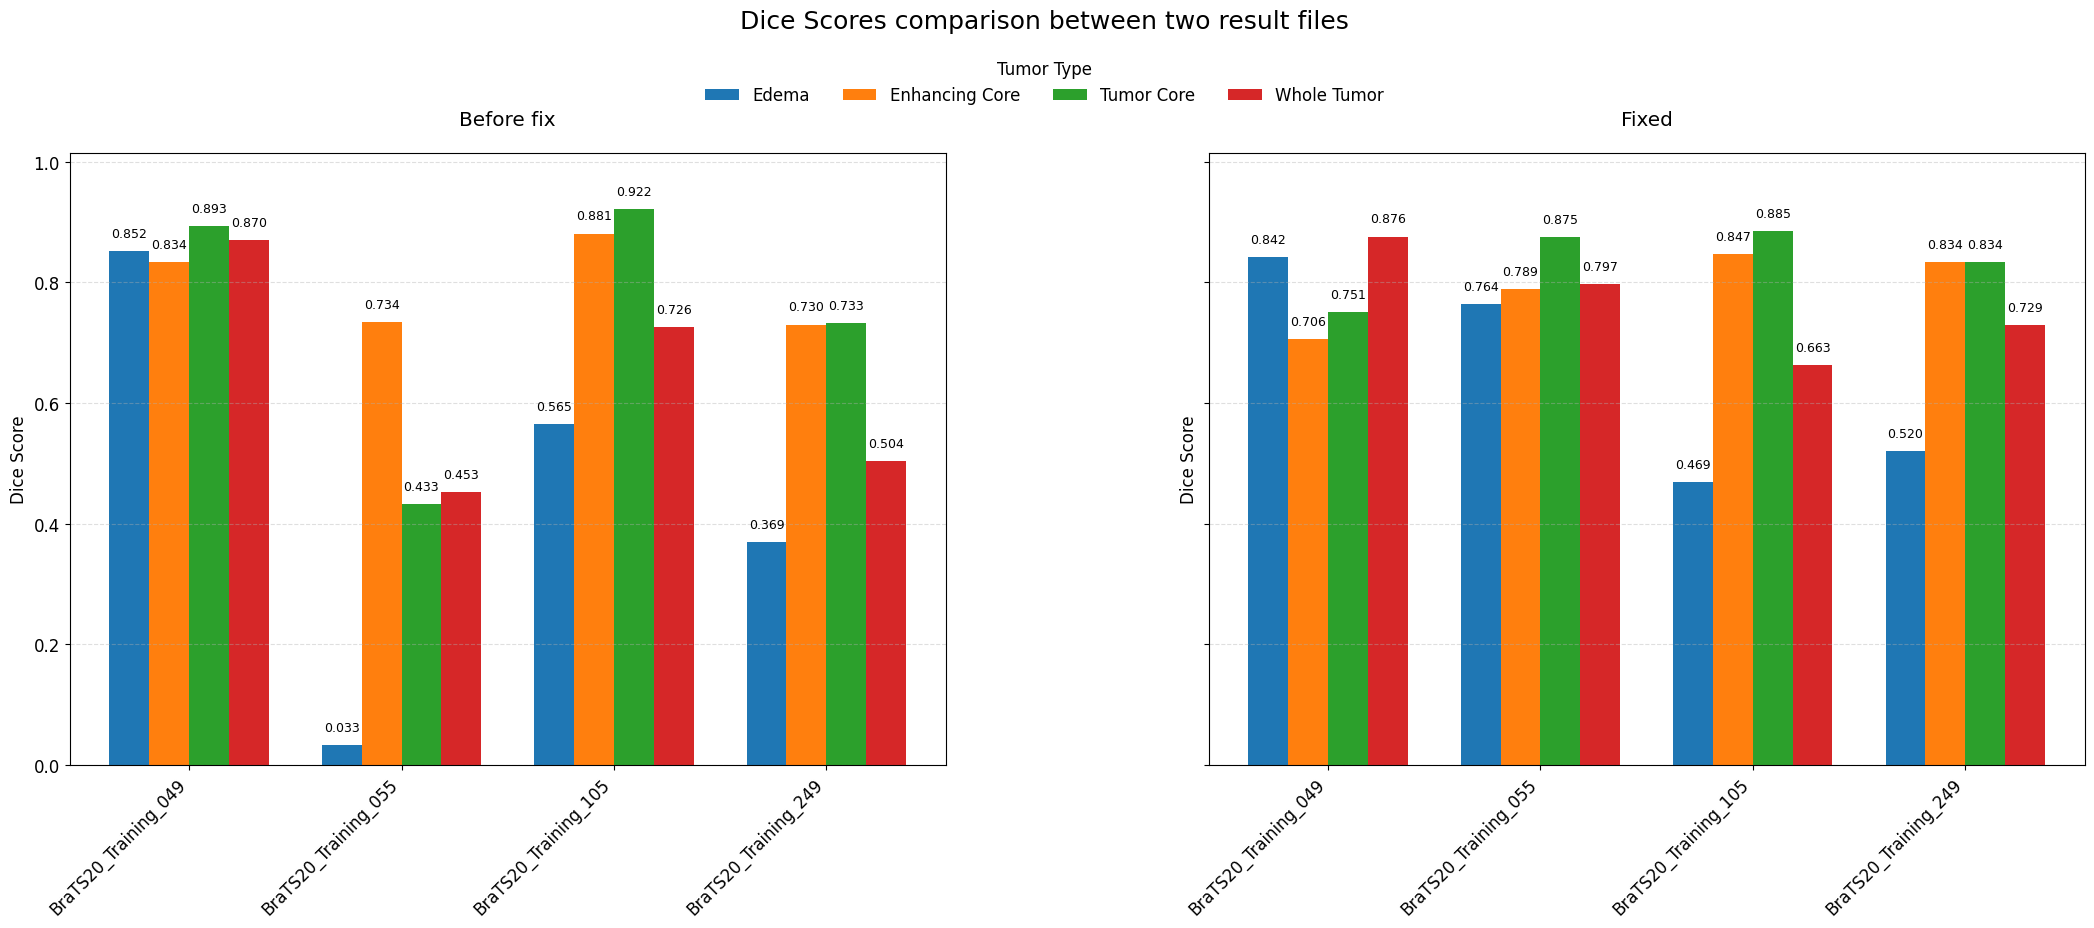

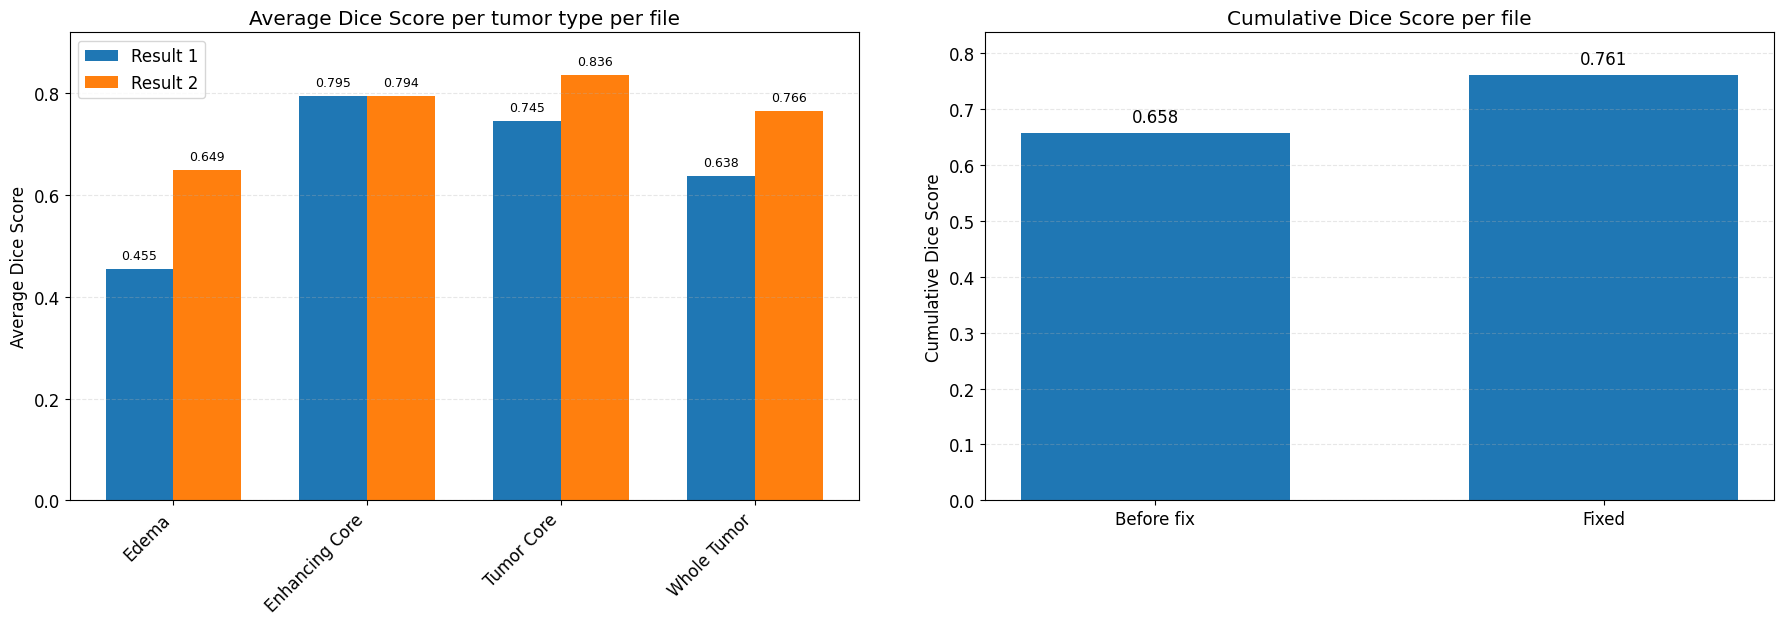

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# List of input txt files
input_paths = [
    "/content/drive/My Drive/Allamvizsga/OutputCNN/Elso_tesztek/EredmenyJ1/output.txt",
    "/content/drive/My Drive/Allamvizsga/OutputCNN/Elso_tesztek/EredmenyJ2/output.txt",
]

# Output directory and file name
output_dir = "/content/drive/My Drive/Allamvizsaga_Dice/Dice_Score"
os.makedirs(output_dir, exist_ok=True)

# Regular expressions for parsing
pattern_map  = re.compile(r"Folder name:\s*(\S+)")
pattern_type = re.compile(r"Tumor type:\s*(.+)")
pattern_ds   = re.compile(r"DS:\s*([0-9]*\.?[0-9]+)")

# Reading data from each file
all_data = []
for path in input_paths:
    data = {}
    with open(path, "r", encoding="utf-8") as f:
        current_map = None
        current_type = None
        for line in f:
            m_map = pattern_map.search(line)
            if m_map:
                current_map = m_map.group(1)
                data.setdefault(current_map, {})
                continue

            m_type = pattern_type.search(line)
            if m_type:
                current_type = m_type.group(1)
                continue

            m_ds = pattern_ds.search(line)
            if m_ds and current_map and current_type:
                data[current_map][current_type] = float(m_ds.group(1))
                current_type = None
    all_data.append(data)

# Listing all unique map and tumor types
maps        = sorted({m for d in all_data for m in d})
tumor_types = sorted({t for d in all_data for m in d.values() for t in m})

# First figure: original comparison
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 2, figsize=(26, 9), sharey=True)
colors     = plt.cm.tab10.colors
width      = 0.75 / len(tumor_types)
x_positions = list(range(len(maps)))

# Y-axis maximum value
all_scores = [score for dataset in all_data for scores in dataset.values() for score in scores.values()]
ymax = max(all_scores) * 1.1

for ax, data, subtitle in zip(axes, all_data, ["Before fix", "Fixed"]):
    ax.set_ylim(0, ymax)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    for i, tt in enumerate(tumor_types):
        vals = [data.get(m, {}).get(tt, 0) for m in maps]
        xs  = [x + i * width for x in x_positions]
        bars = ax.bar(xs, vals, width=width, label=tt, color=colors[i % len(colors)])
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{h:.3f}", xy=(bar.get_x() + bar.get_width()/2, h),
                        xytext=(0, 8), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9, clip_on=False)

    tick_locs = [x + width*(len(tumor_types)-1)/2 for x in x_positions]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(maps, rotation=45, ha="right")
    ax.set_title(subtitle, pad=20)
    ax.set_ylabel("Dice Score")

fig.suptitle("Dice Scores comparison between two result files",
             fontsize=18, y=0.96)
fig.legend(tumor_types,
           title="Tumor Type",
           loc="upper center",
           bbox_to_anchor=(0.5, 0.92),
           ncol=len(tumor_types),
           frameon=False)
plt.subplots_adjust(top=0.80, wspace=0.3, bottom=0.12)
first_fig_path = os.path.join(output_dir, "dice_scores_comparison_horizontal.png")
plt.savefig(first_fig_path, dpi=300, bbox_inches="tight")
print(f"Saved comparison plot: {first_fig_path}")

# Second figure: averages and cumulative Dice score (side by side)
# Average per tumor type per file
avg_per_type = []
overall_scores = []
for data in all_data:
    type_avgs = {}
    all_vals = []
    for tt in tumor_types:
        vals = [data[m][tt] for m in maps if tt in data[m]]
        if vals:
            type_avgs[tt] = np.mean(vals)
            all_vals.extend(vals)
        else:
            type_avgs[tt] = 0.0
    avg_per_type.append(type_avgs)
    overall_scores.append(np.mean(all_vals) if all_vals else 0.0)

# Creating the figure: 1 row, 2 columns
fig2, axes2 = plt.subplots(1, 2, figsize=(18, 6))
width2 = 0.35
x = np.arange(len(tumor_types))

# Average per tumor type
max_avg = 0
for i, avgs in enumerate(avg_per_type):
    vals = [avgs[tt] for tt in tumor_types]
    max_avg = max(max_avg, max(vals))
    bars = axes2[0].bar(x + i*width2, vals, width2, label=f"Result {i+1}")
    for xi, h in zip(x + i*width2, vals):
        axes2[0].annotate(f"{h:.3f}", xy=(xi, h), xytext=(0, 5), textcoords="offset points",
                          ha="center", va="bottom", fontsize=9, clip_on=False)

axes2[0].set_xticks(x + width2/2)
axes2[0].set_xticklabels(tumor_types, rotation=45, ha="right")
axes2[0].set_ylabel("Average Dice Score")
axes2[0].set_title("Average Dice Score per tumor type per file")
axes2[0].set_ylim(0, max_avg * 1.1)
axes2[0].legend()
axes2[0].grid(axis='y', linestyle='--', alpha=0.3)

# Cumulative values per file
max_overall = max(overall_scores) if overall_scores else 0
bars2 = axes2[1].bar([1, 2], overall_scores, width=0.6)
for xi, h in zip([1, 2], overall_scores):
    axes2[1].annotate(f"{h:.3f}", xy=(xi, h), xytext=(0, 5), textcoords="offset points",
                      ha="center", va="bottom", fontsize=12, clip_on=False)
axes2[1].set_xticks([1, 2])
axes2[1].set_xticklabels(["Before fix", "Fixed"])
axes2[1].set_ylabel("Cumulative Dice Score")
axes2[1].set_title("Cumulative Dice Score per file")
axes2[1].set_ylim(0, max_overall * 1.1)
axes2[1].grid(axis='y', linestyle='--', alpha=0.3)

# Layout és mentés
plt.tight_layout(w_pad=4)
fig2.subplots_adjust(top=0.90, bottom=0.12)
second_fig_path = os.path.join(output_dir, "dice_scores_averages_overall_side_by_side.png")
plt.savefig(second_fig_path, dpi=300, bbox_inches="tight")
print(f"Saved averages & overall side-by-side plot: {second_fig_path}")


<ipython-input-2-602499606>:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(types, rotation=45, ha='right')


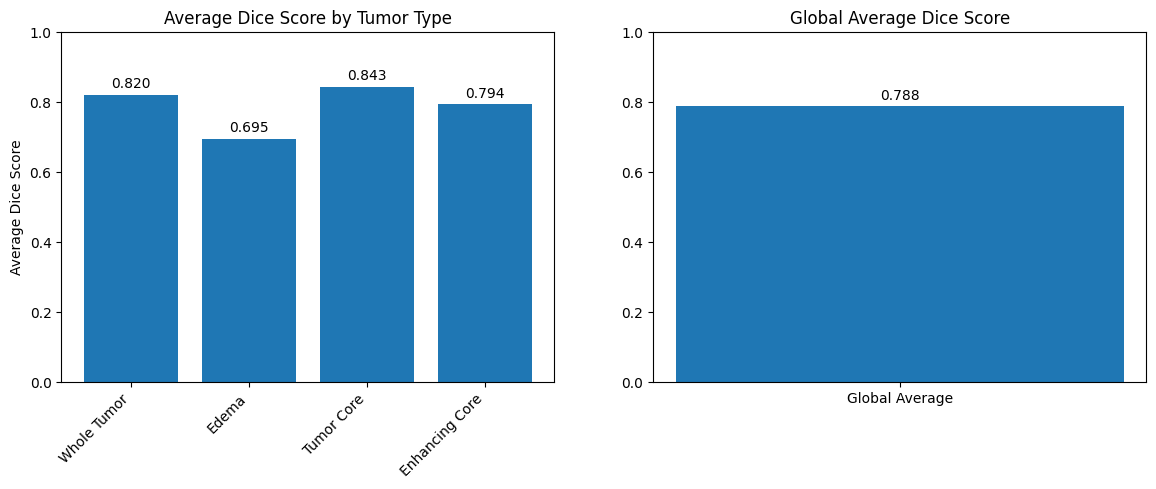

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np

# 1. Reading and processing
file_path = '/content/drive/My Drive/Allamvizsga/OutputCNN/Eredmeny/output.txt'

tumor_scores_global = {}
tumor_scores_by_folder = {}

with open(file_path, 'r', encoding='utf-8') as f:
    content = f.read()

# Split the file content into header/body blocks by "Folder name"
blocks = re.split(r'(Folder name:\s*.+)', content)
for i in range(1, len(blocks), 2):
    header = blocks[i]
    body = blocks[i + 1]
    folder = re.search(r'Folder name:\s*(.+)', header).group(1).strip()

    # Extract tumor type and Dice Score (DS) from the body
    match_tumor = re.search(r'Tumor type:\s*(.+)', body)
    match_ds = re.search(r'DS:\s*([0-9]*\.?[0-9]+)', body)
    if not (match_tumor and match_ds):
        continue

    tumor = match_tumor.group(1).strip()
    ds = float(match_ds.group(1))

    # Accumulate scores globally and by folder
    tumor_scores_global.setdefault(tumor, []).append(ds)
    tumor_scores_by_folder.setdefault(folder, {}).setdefault(tumor, []).append(ds)

# 2. Computing averages
types = list(tumor_scores_global.keys())
avg_global_by_type = [np.mean(tumor_scores_global[t]) for t in types]

# Compute overall Dice Score average across all tumors
all_ds = [score for scores in tumor_scores_global.values() for score in scores]
global_avg = np.mean(all_ds) if all_ds else 0.0

folders = list(tumor_scores_by_folder.keys())
avg_by_folder_and_type = np.zeros((len(folders), len(types)))

for i, folder in enumerate(folders):
    for j, tumor in enumerate(types):
        vals = tumor_scores_by_folder[folder].get(tumor, [])
        avg_by_folder_and_type[i, j] = np.mean(vals) if vals else np.nan

# 3. Plotting – 2x2 layout (bottom row has only one plot spanning both columns)
fig = plt.figure(figsize=(14, 10))

# --- Plot 1: Average Dice Score by tumor type ---
ax1 = fig.add_subplot(2, 2, 1)
bars1 = ax1.bar(types, avg_global_by_type)
ax1.set_title('Average Dice Score by Tumor Type')
ax1.set_ylabel('Average Dice Score')
ax1.set_ylim(0, 1)
ax1.set_xticklabels(types, rotation=45, ha='right')

# Add value labels above each bar
for bar, val in zip(bars1, avg_global_by_type):
    ax1.text(bar.get_x() + bar.get_width() / 2, val + 0.02, f'{val:.3f}', ha='center')

# --- Plot 2: Global average Dice Score ---
ax2 = fig.add_subplot(2, 2, 2)
bar2 = ax2.bar(['Global Average'], [global_avg], width=0.4)
ax2.set_title('Global Average Dice Score')
ax2.set_ylim(0, 1)

for bar in bar2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.3f}', ha='center')



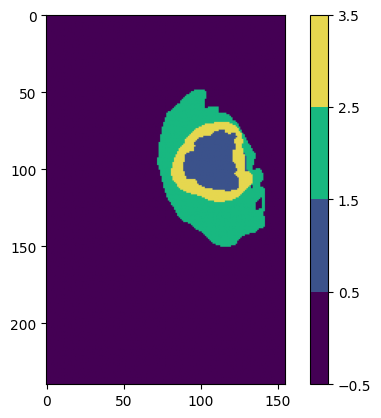

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl
# Plot a segmantation
some_seg_img = nib.load("/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/BraTS20_Training_369_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

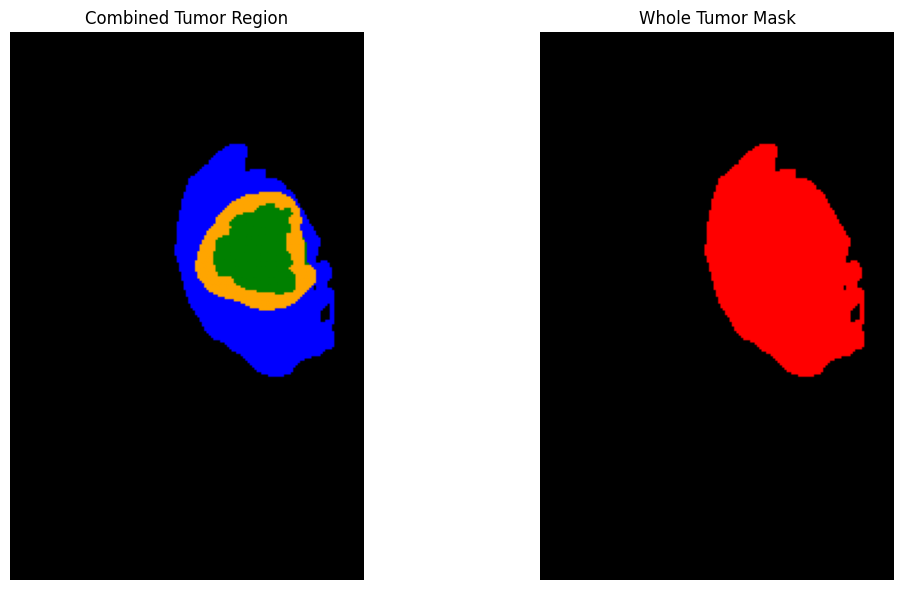

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

# Loading the segmentation
seg_path = "/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/BraTS20_Training_369_seg.nii"
seg_img = nib.load(seg_path).get_fdata()

# Replacing label 4 with 3
def remap_segmentation(seg):
    seg_new = np.copy(seg)
    seg_new[seg == 4] = 3
    return seg_new

seg_img_cnn = remap_segmentation(seg_img)

# Creating binary masks based on the remapped segmentation (0, 1, 2, 3)
# Whole Tumor (WT) -> (1,2,3)
whole_tumor_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
whole_tumor_mask[np.isin(seg_img_cnn, [1, 2, 3])] = 1

# Edema -> (2)
edema_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
edema_mask[seg_img_cnn == 2] = 1

# Tumor Core -> (1,3)
tumor_core_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
tumor_core_mask[np.isin(seg_img_cnn, [1, 3])] = 1

# Enhancing Core -> (3)
enhancing_core_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
enhancing_core_mask[seg_img_cnn == 3] = 1

# Creating a combined label image
combined_labels = np.zeros_like(whole_tumor_mask, dtype=np.uint8)
combined_labels[whole_tumor_mask == 1]   = 1   # Whole Tumor: red
combined_labels[edema_mask == 1]         = 2   # Edema: blue
combined_labels[tumor_core_mask == 1]    = 3   # Tumor Core: green
combined_labels[enhancing_core_mask == 1] = 4  # Enhancing Core: orange


# For the combined image: 0 -> black, 1 -> red, 2 -> blue, 3 -> green, 4 -> orange
cmap_combined = mpl.colors.ListedColormap(['black', 'red', 'blue', 'green', 'orange'])
bounds_combined = [0, 1, 2, 3, 4, 5]
norm_combined = mpl.colors.BoundaryNorm(bounds_combined, cmap_combined.N)

# For the Whole Tumor mask: 0 -> black, 1 -> red
cmap_whole = mpl.colors.ListedColormap(['black', 'red'])
bounds_whole = [-0.5, 0.5, 1.5]
norm_whole = mpl.colors.BoundaryNorm(bounds_whole, cmap_whole.N)

# Displaying images side by side
slice_index = 100  # Selected slice

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# All tumor regions
axs[0].imshow(combined_labels[slice_index, :, :], cmap=cmap_combined, norm=norm_combined)
axs[0].set_title("Combined Tumor Region")
axs[0].axis("off")

# Separate Whole Tumor mask
axs[1].imshow(whole_tumor_mask[slice_index, :, :], cmap=cmap_whole, norm=norm_whole)
axs[1].set_title("Whole Tumor Mask")
axs[1].axis("off")

plt.tight_layout()
plt.show()


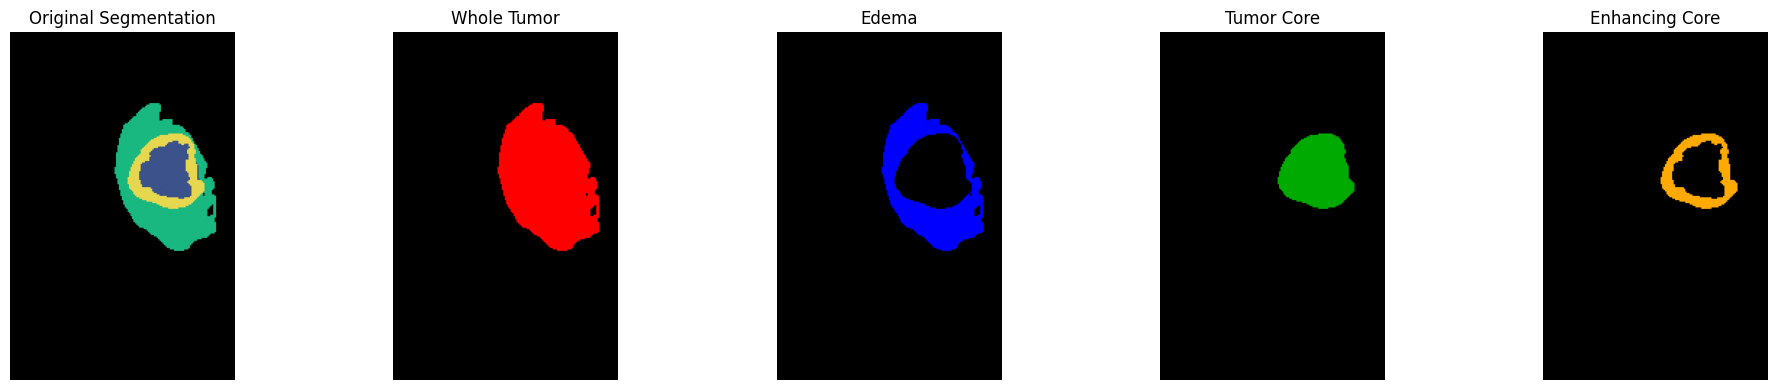

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

# Loading segmentation file
seg_img = nib.load("/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/BraTS20_Training_369_seg.nii").get_fdata()

# remap_segmentation function: replaces the original label 4 with 3
def remap_segmentation(seg):
    seg_new = np.copy(seg)
    seg_new[seg == 4] = 3
    return seg_new

# Apply the remapping to the segmentation
seg_img_cnn = remap_segmentation(seg_img)

# Visualization settings for the remapped segmentation
cmap_cnn = mpl.colors.ListedColormap(['#000000', '#3b528b', '#18b880', '#e6d74f'])
norm_cnn = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap_cnn.N)

# Creating new class definitions in the form of binary masks
# Whole Tumor (WT) -> (1,2,3)
whole_tumor_mask = np.zeros_like(seg_img_cnn)
whole_tumor_mask[np.isin(seg_img_cnn, [1, 2, 3])] = 1

# Edema -> (2)
edema_mask = np.zeros_like(seg_img_cnn)
edema_mask[seg_img_cnn == 2] = 1

# Tumor Core (TC) -> (1,3)
tumor_core_mask = np.zeros_like(seg_img_cnn)
tumor_core_mask[np.isin(seg_img_cnn, [1, 3])] = 1

# Enhancing Core (EC) -> (3)
enhancing_core_mask = np.zeros_like(seg_img_cnn)
enhancing_core_mask[seg_img_cnn == 3] = 1

# Color maps
# Whole Tumor -> red
cmap_whole = mpl.colors.ListedColormap(['#000000', '#ff0000'])
norm_whole = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_whole.N)

# Edema -> blue
cmap_edema = mpl.colors.ListedColormap(['#000000', '#0000ff'])
norm_edema = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_edema.N)

# Tumor Core -> green
cmap_core = mpl.colors.ListedColormap(['#000000', '#00aa00'])
norm_core = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_core.N)

# Enhancing Core -> orange
cmap_enhancing = mpl.colors.ListedColormap(['#000000', '#ffaa00'])
norm_enhancing = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_enhancing.N)

# Visualization
slice_index = 100

fig, axs = plt.subplots(1, 5, figsize=(20, 4))


axs[0].imshow(seg_img_cnn[slice_index, :, :], cmap=cmap_cnn, norm=norm_cnn)
axs[0].set_title("Original Segmentation")
axs[0].axis("off")

# 4.2) Whole Tumor
axs[1].imshow(whole_tumor_mask[slice_index, :, :], cmap=cmap_whole, norm=norm_whole)
axs[1].set_title("Whole Tumor")
axs[1].axis("off")

# 4.3) Edema
axs[2].imshow(edema_mask[slice_index, :, :], cmap=cmap_edema, norm=norm_edema)
axs[2].set_title("Edema")
axs[2].axis("off")

# 4.4) Tumor Core
axs[3].imshow(tumor_core_mask[slice_index, :, :], cmap=cmap_core, norm=norm_core)
axs[3].set_title("Tumor Core")
axs[3].axis("off")

# 4.5) Enhancing Core
axs[4].imshow(enhancing_core_mask[slice_index, :, :], cmap=cmap_enhancing, norm=norm_enhancing)
axs[4].set_title("Enhancing Core")
axs[4].axis("off")

plt.tight_layout()
plt.show()


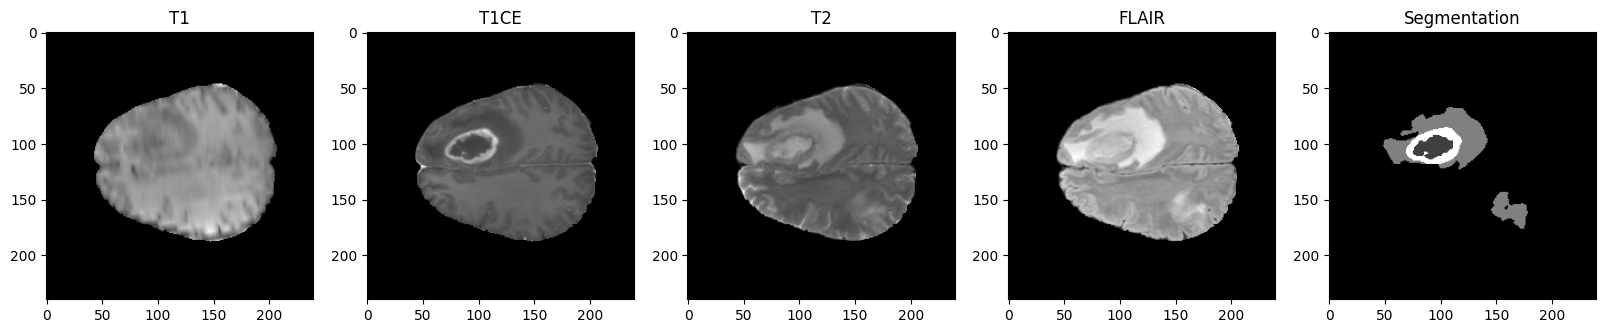

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

sample_path = '/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/'

t1_img    = nib.load(sample_path + 'BraTS20_Training_369_t1.nii')
t1ce_img  = nib.load(sample_path + 'BraTS20_Training_369_t1ce.nii')
t2_img    = nib.load(sample_path + 'BraTS20_Training_369_t2.nii')
flair_img = nib.load(sample_path + 'BraTS20_Training_369_flair.nii')
seg_img   = nib.load(sample_path + 'BraTS20_Training_369_seg.nii')

t1_data    = t1_img.get_fdata()
t1ce_data  = t1ce_img.get_fdata()
t2_data    = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data   = seg_img.get_fdata()

slice_nb = 100
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()
